# Projet 4: Anticipez les besoins en consommation électrique de bâtiments

- Explication variables 2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
- Explication variables 2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

Variables à prédire:
- émissions de CO2 => **TotalGHGEmissions**
- consommation totale d’énergie de bâtiments => **SiteEnergyUse(kBtu)**

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des datasets](#dataset)
3. [Fusion des 2 datasets](#merge)
4. [Filtre sur les bâtiments non destinés à l'habitation](#filter)
5. [Doublons](#doublons)
7. [Valeurs aberrantes](#outliers)
8. [Valeurs manquantes](#nan)
9. [Création de nouvelles variables](#features) 
10. [Analyse exploratoire](#EDA) 

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np
import pandas as pd
from P4_functions import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
from sklearn.impute import KNNImputer

In [3]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

## Chargement et visualisation des datasets <a class="anchor" id="dataset"></a>

In [6]:
data_2015 = pd.read_csv('data/2015-building-energy-benchmarking.csv', sep = ',', encoding ='utf-8')
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [7]:
shape_total_nan(data_2015)

Nombre de lignes: 3340
Nombre de colonnes: 47
Nombre total de NaN du dataset: 26512
% total de NaN du dataset: 16.89%


In [8]:
data_2016 = pd.read_csv('data/2016-building-energy-benchmarking.csv', sep = ',', encoding ='utf-8')
data_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [9]:
shape_total_nan(data_2016)

Nombre de lignes: 3376
Nombre de colonnes: 46
Nombre total de NaN du dataset: 19952
% total de NaN du dataset: 12.85%


## Fusion des 2 datasets <a class="anchor" id="merge"></a>

In [10]:
compar_col(data_2015, data_2016)

Colonnes présentes uniquement dans le 1er dataset: 
 {'City Council Districts', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', 'Seattle Police Department Micro Community Policing Plan Areas', 'OtherFuelUse(kBtu)', 'SPD Beats', 'GHGEmissions(MetricTonsCO2e)', 'Location', '2010 Census Tracts', 'Zip Codes'}
-----------------------------------------------------------------------
Colonnes présentes uniquement dans le 2ème dataset: 
 {'City', 'GHGEmissionsIntensity', 'ZipCode', 'Address', 'TotalGHGEmissions', 'Latitude', 'State', 'Comments', 'Longitude'}


Avant de fusionner les 2 datasets, nous allons:
- renommer les variables identiques
- créer de nouvelles variables lorsque l'information est présente dans une seule colonne (cf colonne Location)
- supprimer les variables présentes sur 2015 mais non reprises sur 2016

Nous vérifierons ensuite que les champs des variables catégorielles sont bien harmonisés entre 2015 et 2016 et filtrerons le dataset sur les bâtiments non résidentiels.

### Renommage des variables identiques

In [11]:
# On renomme les colonnes identiques
data_2015.rename(columns={'Comment': 'Comments', 
                          'Zip Codes': 'ZipCode',
                          'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                          'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, inplace = True)

### Création de nouvelles variables

In [12]:
# Données présentes dans la colonne Location de data_2015
data_2015['Location']

0         {'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
1           {'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
2          {'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
3        {'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{"address": "620 STEWART ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
4           {'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{"address": "401 LENORA ST", "city": "SEATTLE", "state": "WA", "zip": "98121"}'}
                                                                                     ...                                                                             

In [13]:
# Création de nouvelles variables
data_2015['Latitude'] = data_2015['Location'].apply(lambda x: eval(x)['latitude']).astype('float64')
data_2015['Longitude'] = data_2015['Location'].apply(lambda x: eval(x)['longitude']).astype('float64')
data_2015['Human_address'] = data_2015['Location'].apply(lambda x: eval(x)['human_address']).astype('str')
data_2015['Address'] = data_2015['Human_address'].apply(lambda x: eval(x)['address']).astype('str')
data_2015['City'] = data_2015['Human_address'].apply(lambda x: eval(x)['city']).astype('str')
data_2015['State'] = data_2015['Human_address'].apply(lambda x: eval(x)['state']).astype('str')
data_2015['ZipCode'] = data_2015['Human_address'].apply(lambda x: eval(x)['zip']).astype('int32')

In [14]:
# Suppression des variables non nécessaires qui nous ont permis d'extraire les données
data_2015.drop(columns=['Location', 'Human_address'], inplace = True)

In [15]:
data_2015[['Latitude', 'Longitude', 'Address', 'City', 'State', 'ZipCode']].head()

,Latitude,Longitude,Address,City,State,ZipCode
0,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA,98101
1,47.613106,-122.333358,724 PINE ST,SEATTLE,WA,98101
2,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA,98101
3,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA,98101
4,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA,98121


### Suppression des variables présentes sur 2015 uniquement

In [16]:
data_2015.drop(columns=['SPD Beats', '2010 Census Tracts', 'City Council Districts', 'OtherFuelUse(kBtu)',
                       'Seattle Police Department Micro Community Policing Plan Areas'], inplace = True)

### Fusion des 2 datasets

In [17]:
# Vérification que les datasets contiennent les mêmes colonnes
compar_col(data_2015, data_2016)

Colonnes présentes uniquement dans le 1er dataset: 
 set()
-----------------------------------------------------------------------
Colonnes présentes uniquement dans le 2ème dataset: 
 set()


In [18]:
data = pd.concat([data_2015, data_2016]).sort_values('OSEBuildingID')

In [19]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,Address,City,State
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.900000,80.300000,173.500000,175.100000,6981428.0,7097539.0,2023032.0,1.080307e+06,3686160.0,12724.00000,1272388.0,249.43,2.64,No,NaN,Compliant,NaN,98101.0,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83,False,NaN,Compliant,NaN,98101.0,47.612200,-122.337990,405 Olive way,Seattle,WA
1,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86,False,NaN,Compliant,NaN,98101.0,47.613170,-122.333930,724 Pine street,Seattle,WA
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.400000,99.000000,191.300000,195.200000,8354235.0,8765788.0,0.0,1.144563e+06,3905411.0,44490.00000,4448985.0,263.51,2.38,No,NaN,Compliant,NaN,98101.0,47.613106,-122.333358,724 PINE ST,SEATTLE,WA
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.600000,99.700000,242.700000,246.500000,73130656.0,75506272.0,19660404.0,1.458393e+07,49762435.0,37099.00000,3709900.0,2061.48,1.92,Yes,NaN,Compliant,NaN,98101.0,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA


In [20]:
shape_total_nan(data)

Nombre de lignes: 6716
Nombre de colonnes: 46
Nombre total de NaN du dataset: 40207
% total de NaN du dataset: 13.01%


###  Harmonisation des champs des variables catégorielles

####  Description des variables

<div class="alert alert-block alert-info">
    <p> Future warning, comment transformer la fonction? </p>
</div>

In [21]:
describe_variables_light(data.iloc[:, data.columns.isin(data.select_dtypes(include = 'object').columns)])

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_funct

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,BuildingType,object,NonResidential,6716,8,0.12,6716,100.0,0,0.0
1,PrimaryPropertyType,object,Hotel,6716,32,0.48,6716,100.0,0,0.0
2,PropertyName,object,MAYFLOWER PARK HOTEL,6716,6527,97.19,6716,100.0,0,0.0
3,TaxParcelIdentificationNumber,object,659000030,6716,3729,55.52,6714,99.97,2,0.03
4,Neighborhood,object,DOWNTOWN,6716,19,0.28,6716,100.0,0,0.0
5,ListOfAllPropertyUseTypes,object,Hotel,6716,488,7.27,6580,97.97,136,2.03
6,LargestPropertyUseType,object,Hotel,6716,57,0.85,6560,97.68,156,2.32
7,SecondLargestPropertyUseType,object,Parking,6716,50,0.74,3238,48.21,3478,51.79
8,ThirdLargestPropertyUseType,object,Restaurant,6716,45,0.67,1156,17.21,5560,82.79
9,YearsENERGYSTARCertified,object,2016,6716,116,1.73,229,3.41,6487,96.59


C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_funct

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\04_PROJET_4\P4_functions.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,


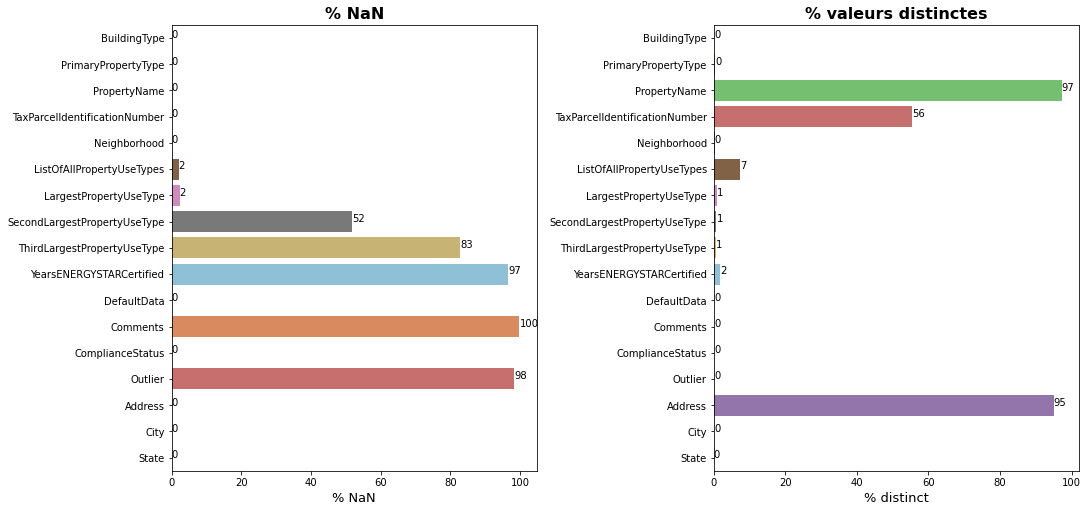

In [22]:
completion_distinct_plots(data.iloc[:, data.columns.isin(data.select_dtypes(include = 'object').columns)])

####  Modalités des variables

In [23]:
# Différentes modalités des variables catégorielles sélectionnées

liste_col_categ = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'DefaultData', 'ComplianceStatus', 
                   'Outlier', 'City','State']

print('Modalités des colonnes:')
for column in liste_col_categ:
    #data[column] = data[column].astype(str)
    data[column] = data[column].str.title()
    print()
    print(f"***{column}***")
    print(data[column].value_counts())
    #print(sorted(data[column].unique())[0:60])
    print("--------------------------------------------------------------")

Modalités des colonnes:

***BuildingType***
Nonresidential          2921
Multifamily Lr (1-4)    2047
Multifamily Mr (5-9)    1134
Multifamily Hr (10+)     217
Sps-District K-12        197
Nonresidential Cos       153
Campus                    46
Nonresidential Wa          1
Name: BuildingType, dtype: int64
--------------------------------------------------------------

***PrimaryPropertyType***
Low-Rise Multifamily           1985
Mid-Rise Multifamily           1103
Small- And Mid-Sized Office     590
Other                           514
Large Office                    344
K-12 School                     275
Mixed Use Property              259
High-Rise Multifamily           208
Retail Store                    191
Non-Refrigerated Warehouse      187
Warehouse                       187
Hotel                           150
Worship Facility                143
Senior Care Community            88
Medical Office                   82
Distribution Center              55
Distribution Center\n    

In [24]:
# Harmonisation des modalités de BuildingType
data.loc[data['BuildingType'] == 'Nonresidential Wa', 'BuildingType'] = 'Nonresidential'

In [25]:
# Harmonisation des modalités de PrimaryPropertyType
data.loc[data['PrimaryPropertyType'] == 'Self-Storage Facility\n', 'PrimaryPropertyType'] = 'Self-Storage Facility'
data.loc[data['PrimaryPropertyType'] == 'Distribution Center\n', 'PrimaryPropertyType'] = 'Distribution Center'
data.loc[data['PrimaryPropertyType'] == 'Supermarket / Grocery Store', 'PrimaryPropertyType'] = 'Supermarket/Grocery Store'
data.loc[data['PrimaryPropertyType'] == 'Restaurant\n', 'PrimaryPropertyType'] = 'Restaurant'
data.loc[data['PrimaryPropertyType'] == 'Residence Hall/Dormitory', 'PrimaryPropertyType'] = 'Residence Hall'
data.loc[data['PrimaryPropertyType'] == 'University', 'PrimaryPropertyType'] = 'College/University'
data.loc[data['PrimaryPropertyType'] == 'Sps-District K-12', 'PrimaryPropertyType'] = 'K-12 School'

In [26]:
# Harmonisation des modalités de Neighborhood
data.loc[data['Neighborhood'] == 'Delridge Neighborhoods', 'Neighborhood'] = 'Delridge'

In [27]:
# Amélioration des modalités de la colonne YearsENERGYSTARCertified
def split_years(x):
    x_str = str(x).replace('nan', '')
    if ',' in x_str:
        years = [i.strip() for i in str(x_str).split(',')]
    elif len(x_str)%4==0:
        #years = [x_str[4*(i):4*(i+1)] for i in range(int(len(x_str)/4))]
        years = [x_str[i:i+4] for i in range(0, len(x_str), 4)]
    else:
        years = x_str
    return tuple(years)

data['YearsENERGYSTARCertified'] = data['YearsENERGYSTARCertified'].apply(lambda x: split_years(x))

#data['YearsENERGYSTARCertified'].fillna('Not Certified', inplace = True)

In [28]:
# Suppression de la variable Comments, State et City
data.drop(['Comments', 'State', 'City'], axis = 'columns', inplace = True)

In [29]:
# Harmonisation des modalités de ComplianceStatus
data.loc[data['ComplianceStatus'] == 'Not Compliant', 'ComplianceStatus'] = 'Non-Compliant'

####  Complétion des variables catégorielles en fonction de l'ID du bâtiment

<div class="alert alert-block alert-info">
    <p> name 'np' is not defined quand fonction dans P4_funtions.py </p>
</div>

In [30]:
def mapping(dataframe, var_to_map, var_mapping):
    table_mapping = dataframe.groupby([var_mapping, var_to_map])['DataYear'].count().reset_index()
    table_mapping = table_mapping.sort_values(var_to_map, ascending = True) # sur col txt
    table_mapping = table_mapping.drop_duplicates(subset = var_mapping, keep = 'first') # first car nan after
    
    # Merge du dataframe avec la table de mapping
    df = pd.merge(left = dataframe, right = table_mapping[[var_mapping, var_to_map]], 
                  how = "left", on = var_mapping)
    
    # Lorsque la var_to_map est NaN, je complète avec la valeur du mapping
    df[f'{var_to_map}_x'] = np.where(df[f'{var_to_map}_x'].isnull(), 
                                     df[f'{var_to_map}_y'], 
                                     df[f'{var_to_map}_x'])
    
    # On supprime la variable issue de la jointure et on enlève le suffixe _x
    df.rename(columns={f'{var_to_map}_x': var_to_map}, inplace = True)
    df.drop(f'{var_to_map}_y', axis = 'columns', inplace = True)
    
    return df

In [31]:
# Mapping de ListOfAllPropertyUseTypes
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'ListOfAllPropertyUseTypes', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN après mapping: 2.32 %
% NaN après mapping: 2.32 %


In [32]:
# Mapping de LargestPropertyUseType
print(f"% NaN avant mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'LargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['LargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 2.32 %
% NaN après mapping: 0.61 %


In [33]:
# Mapping de SecondLargestPropertyUseType
print(f"% NaN avant mapping: {round(data['SecondLargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'SecondLargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['SecondLargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 51.790000000000006 %
% NaN après mapping: 50.33 %


In [34]:
# Mapping de ThirdLargestPropertyUseType
print(f"% NaN avant mapping: {round(data['ThirdLargestPropertyUseType'].isna().mean(),4)*100} %")
data = mapping(data, 'ThirdLargestPropertyUseType', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['ThirdLargestPropertyUseType'].isna().mean(),4)*100} %")

% NaN avant mapping: 82.78999999999999 %
% NaN après mapping: 82.3 %


In [35]:
# Mapping de TaxParcelIdentificationNumber
print(f"% NaN avant mapping: {round(data['TaxParcelIdentificationNumber'].isna().mean(),4)*100} %")
data = mapping(data, 'TaxParcelIdentificationNumber', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['TaxParcelIdentificationNumber'].isna().mean(),4)*100} %")

% NaN avant mapping: 0.03 %
% NaN après mapping: 0.01 %


In [36]:
# Mapping de DefaultData
print(f"% NaN avant mapping: {round(data['DefaultData'].isna().mean(),4)*100} %")
data = mapping(data, 'DefaultData', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['DefaultData'].isna().mean(),4)*100} %")

% NaN avant mapping: 50.28 %
% NaN après mapping: 1.4000000000000001 %


In [37]:
# Mapping de Outlier
print(f"% NaN avant mapping: {round(data['Outlier'].isna().mean(),4)*100} %")
data = mapping(data, 'Outlier', 'OSEBuildingID')
print(f"% NaN après mapping: {round(data['Outlier'].isna().mean(),4)*100} %")

% NaN avant mapping: 98.27 %
% NaN après mapping: 97.19 %


## Filtre sur les bâtiments non destinés à l'habitation <a class="anchor" id="filter"></a>

Nous nous intéressons aux émissions des bâtiments **non destinés à l’habitation**. Nous allons donc filtrer le dataset sur les bâtiments non résidentiels. Pour ce faire, nous nous baserons sur le champ **PrimaryPropertyType** qui correspond à l'utilisation principale (+ de 50%) d'une propriété. Ce champ a l'avantage d'être plus détaillé que le BuildingType et se base sur l'utilisation principale du bâtiment alors que le champ LargestPropertyUseType est basé sur sa superficie.

In [38]:
data_gpby_type = data.groupby(['PrimaryPropertyType', 'LargestPropertyUseType'])['OSEBuildingID'].count()
data_gpby_type

PrimaryPropertyType          LargestPropertyUseType                              
College/University           College/University                                        46
                             Office                                                     1
Distribution Center          Distribution Center                                      105
                             Non-Refrigerated Warehouse                                 1
High-Rise Multifamily        Multifamily Housing                                      206
Hospital                     Hospital (General Medical & Surgical)                     20
Hotel                        Hotel                                                    149
K-12 School                  K-12 School                                              279
Laboratory                   Laboratory                                                11
Large Office                 Office                                                   344
Low-Rise Multifami

In [39]:
# Filtre sur les bâtiments non destinés à l'habitation
PrimaryPropertyType_to_delete = ['High-Rise Multifamily','Low-Rise Multifamily', 'Mid-Rise Multifamily']
data = data[~data['PrimaryPropertyType'].isin(PrimaryPropertyType_to_delete)]

In [40]:
shape_total_nan(data)

Nombre de lignes: 3420
Nombre de colonnes: 43
Nombre total de NaN du dataset: 13468
% total de NaN du dataset: 9.16%


## Doublons <a class="anchor" id="doublons"></a>

Lorsque plusieurs **OSEBuildingID** sont identiques, nous conserverons la ligne de celui contenant le **moins de valeurs manquantes**. Il est important de n'avoir que des OSEBuildingID uniques lorsque nous séparerons le dataset en données d'entrainement et de test afin de ne pas prédire la consommation d'un bâtiment qui aurait déjà été vu par notre algorithme.

In [41]:
# Nombre de doublons sur la colonne OSEBuildingID
print(f"Codes en doublons: {data.duplicated('OSEBuildingID').sum()}")

Codes en doublons: 1669


In [42]:
# Supprimons les lignes dupliquées qui ont le plus grand nombre de NaN
data['null_count'] = data.isnull().sum(1)

data = data.sort_values('null_count')\
       .drop_duplicates(subset = "OSEBuildingID")\
       .sort_index()

In [43]:
# Suppression de la variable null_count
data.drop('null_count', axis='columns', inplace = True)

In [44]:
shape_total_nan(data)

Nombre de lignes: 1751
Nombre de colonnes: 43
Nombre total de NaN du dataset: 6813
% total de NaN du dataset: 9.05%


In [45]:
#data.to_excel("data_cleaned.xlsx") 

## Valeurs aberrantes <a class="anchor" id="outliers"></a>

Nous allons vérifier la cohérence de certaines variables qui peuvent être recalculées:
- la **quantité annuelle d'énergie consommée par la propriété**, toutes sources d'énergie confondues (SiteEnergyUse(kBtu)) ne peut être égale ou inférieure à 0
- la **quantité annuelle de CO2 consommé par la propriété** (TotalGHGEmissions) ne peut être égale ou inférieure à 0
- le **nombre de bâtiments** ne peut être inférieur ou égal à 0
- la **somme de toutes les sources d'énergie** (vapeur, électricité, gaz naturel) doit être proche de la valeur de la variable SiteEnergyUse(kBtu)
- la **surface des bâtiments + parkings** (PropertyGFATotal) est bien égale à la surface des bâtiments (PropertyGFABuilding(s)) et du parking (PropertyGFAParking)
- la **surface des bâtiments + parkings** (PropertyGFATotal) est bien égale à la surface des bâtiments la plus importante (LargestPropertyUseTypeGFA), suive de la 2ème et 3ème surface la plus importante (SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA)

In [46]:
# SiteEnergyUse(kBtu) strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['SiteEnergyUse(kBtu)'] <= 0].shape[0]}")
data = data[data['SiteEnergyUse(kBtu)'] > 0]

Nb de lignes à supprimer: 4


In [47]:
# TotalGHGEmissions strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['TotalGHGEmissions'] <= 0].shape[0]}")
data = data[data['TotalGHGEmissions'] > 0]

Nb de lignes à supprimer: 1


In [48]:
# TotalGHGEmissions strictement supérieur à 0
print(f"Nb de lignes à supprimer: {data[data['NumberofBuildings'] <= 0].shape[0]}")
data = data[data['NumberofBuildings'] > 0]

Nb de lignes à supprimer: 24


In [49]:
# Somme des sources d'énergie proche de SiteEnergyUse(kBtu) (plus ou moins 10%)
energy_cols = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']


data['energy_sum'] = data[energy_cols].sum(axis='columns')
energy_sum_sup_10_percent = ~data['energy_sum'].between(data['SiteEnergyUse(kBtu)']*0.9,
                                                        data['SiteEnergyUse(kBtu)']*1.1)
print(f"Nb de lignes à supprimer: {data[energy_sum_sup_10_percent].shape[0]}")

data = data[~energy_sum_sup_10_percent]
data.drop('energy_sum', axis='columns', inplace = True)

Nb de lignes à supprimer: 8


In [50]:
# Surface PropertyGFATotal = PropertyGFABuilding(s) + PropertyGFAParking
print(f"Nb de lignes à supprimer: {data[~data['PropertyGFATotal'] == data['PropertyGFABuilding(s)'] + data['PropertyGFAParking']].shape[0]}")

Nb de lignes à supprimer: 0


In [51]:
# PropertyGFATotal = LargestPropertyUseTypeGFA + SecondLargestPropertyUseTypeGFA + ThirdLargestPropertyUseTypeGFA
largest_cols = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

data[largest_cols] = data[largest_cols].fillna(0)
data['GFA_sum'] = data[largest_cols].sum(axis='columns')

GFA_sum_sup_10_percent = ~data['GFA_sum'].between(data['PropertyGFATotal']*0.9,
                                                  data['PropertyGFATotal']*1.1)
print(f"Nb de lignes non comprises dans l'intervalle [90%-110%]: {data[GFA_sum_sup_10_percent].shape[0]}")

GFA_sum_sup_20_percent = ~data['GFA_sum'].between(data['PropertyGFATotal']*0.8,
                                                  data['PropertyGFATotal']*1.2)
print(f"Nb de lignes non comprises dans l'intervalle [80%-120%]: {data[GFA_sum_sup_20_percent].shape[0]}")

Nb de lignes non comprises dans l'intervalle [90%-110%]: 424
Nb de lignes non comprises dans l'intervalle [80%-120%]: 268


Nous allons ici comparer le nombre de lignes qui ne rentrent pas dans l'intervalle [80%-120%] au nombre d'observations initiales afin de nous assurer que leur suppression n'aura pas de réelle incidence sur la qualité de nos données.

In [53]:
GFA_sum_sup_20_percent_gpby_type = data[GFA_sum_sup_20_percent].groupby(['PrimaryPropertyType', 
                                                                         'LargestPropertyUseType'])['OSEBuildingID'].count().reset_index()

In [55]:
GFA_sum_sup_20_percent_gpby_type = pd.merge(left = data_gpby_type, right = GFA_sum_sup_20_percent_gpby_type, 
                  how = "left", on = ['PrimaryPropertyType', 'LargestPropertyUseType'])
GFA_sum_sup_20_percent_gpby_type.rename(columns={'OSEBuildingID_x': 'total_rows', 
                                                 'OSEBuildingID_y': 'rows_to_delete'}, inplace = True)

GFA_sum_sup_20_percent_gpby_type['rows_to_delete'] = GFA_sum_sup_20_percent_gpby_type['rows_to_delete'].fillna(0)

In [57]:
GFA_sum_sup_20_percent_gpby_type['rows_toDelete%'] = (GFA_sum_sup_20_percent_gpby_type['rows_to_delete'] / GFA_sum_sup_20_percent_gpby_type['total_rows'])*100

In [63]:
GFA_sum_sup_20_percent_gpby_type

,PrimaryPropertyType,LargestPropertyUseType,total_rows,rows_to_delete,rows_toDelete%
0,College/University,College/University,46,0.0,0.000000
1,College/University,Office,1,0.0,0.000000
2,Distribution Center,Distribution Center,105,3.0,2.857143
3,Distribution Center,Non-Refrigerated Warehouse,1,0.0,0.000000
4,High-Rise Multifamily,Multifamily Housing,206,0.0,0.000000
5,Hospital,Hospital (General Medical & Surgical),20,7.0,35.000000
6,Hotel,Hotel,149,10.0,6.711409
7,K-12 School,K-12 School,279,12.0,4.301075
8,Laboratory,Laboratory,11,0.0,0.000000
9,Large Office,Office,344,28.0,8.139535


In [62]:
GFA_sum_sup_20_percent_gpby_type[GFA_sum_sup_20_percent_gpby_type['rows_toDelete%']>50].shape[0]

0

La suppression des lignes qui ne rentrent pas dans l'intervalle [80%-120%] ne représentant pas plus de 50% du nombre initial d'observations ayant le même PrimaryPropertyType et LargestPropertyUseType, je décide de les supprimer sans trop de risque de perdre de l'information.

In [68]:
data = data[~GFA_sum_sup_20_percent]
data.drop('GFA_sum', axis='columns', inplace = True)

In [69]:
shape_total_nan(data)

Nombre de lignes: 1445
Nombre de colonnes: 43
Nombre total de NaN du dataset: 3800
% total de NaN du dataset: 6.12%


## Valeurs manquantes <a class="anchor" id="nan"></a>

In [80]:
# Copie du dataset
data_clean = data.copy()

Nous allons imputer les valeurs manquantes de différentes manières:

- **suppression de la variable DefaultData** qui ne nous apporte pas de complément d'information
- **constante 'Not an Outlier"** pour la variable Outlier
- pour les variables sur le **type des bâtiments** (SecondLargestPropertyUseType et ThirdLargestPropertyUseType), nous imputerons les valeurs manquantes par la **constante 'None'** car il s'agit de bâtiments n'ayant qu'un usage principal ou secondaire
- **K Nearest Neighboors** pour les variables **ZipCode** et **ENERGYSTARScore**

In [103]:
print('Taux de remplissage:')
not_nan_percent = round(data_clean.notna().mean().sort_values(ascending = False),4)*100
not_nan_percent[not_nan_percent < 100]

Taux de remplissage:


ENERGYSTARScore    68.65
dtype: float64

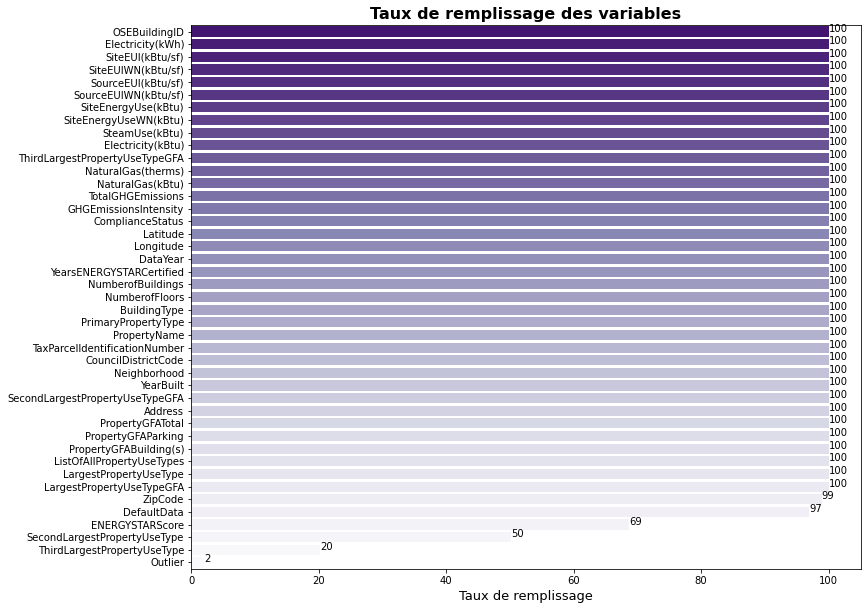

In [72]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(y = not_nan_percent.index, x = not_nan_percent.values, palette = 'Purples_r')
plt.title("Taux de remplissage des variables")
plt.ylabel("")
plt.xlabel("Taux de remplissage")
etiquette_h(ax)
# plt.axvline(x = 20, color = 'r');
#plt.text(42, -1, '>40%', color='r');

In [82]:
# Suppression de la variable DefaultData
data_clean = data_clean.drop('DefaultData', axis = 'columns', inplace = False)

In [83]:
# Imputation de la variable 'Outlier' par la constante 'None'
data_clean['Outlier'] = data_clean['Outlier'].fillna('Not an Outlier')

In [84]:
# Imputation des variables SecondLargestPropertyUseType et ThirdLargestPropertyUseType par la constante None
data_clean[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = data_clean[['SecondLargestPropertyUseType', 
                                                                                          'ThirdLargestPropertyUseType']].fillna('None')

<div class="alert alert-block alert-info">
    <p> knn transforme mon zipcode en float. Quelle serait la meilleure méthode? j'ai rajouté .astype(int) mais je ne sais pas ce que ça vaut </p>
</div>

In [100]:
# KNN sur le ZipCode

# Colonnes impactées
col_knn = ['ZipCode', 'Latitude', 'Longitude']

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(data_clean[col_knn])

imputed

array([[ 9.81010000e+04,  4.76121902e+01, -1.22337997e+02],
       [ 9.81010000e+04,  4.76131700e+01, -1.22333930e+02],
       [ 9.81010000e+04,  4.76133490e+01, -1.22337699e+02],
       ...,
       [ 9.81156667e+04,  4.76364400e+01, -1.22357840e+02],
       [ 9.81080000e+04,  4.75283200e+01, -1.22324310e+02],
       [ 9.81113333e+04,  4.75393900e+01, -1.22295360e+02]])

In [101]:
# affectation des résultats de l'algorithme dans la variable ZipCode
data_clean['ZipCode'] = imputed.astype(int)[:,0]

<div class="alert alert-block alert-info">
    <p> comment savoir si mon KNN donne de bons résultats? Comme il y a une question sur l'energystarscore, faut il remplacer les Nan? </p>
</div>

In [ ]:
# KNN sur l' ENERGYSTARScore

## Création de nouvelles variables <a class="anchor" id="features"></a>

Nous pouvons déduire de nouvelles variables à partir des données existantes dans le dataset. Ce procédé s'appelle le feature engineering. Il s'agit de créer de nouvelles variables qui seront utilisées en apprentissage supervisé. En effet, pour que les algorithmes de Machine Learning fonctionnent bien sur de nouvelles données, il peut être nécessaire de créer et entrainer de nouvelles variables. Voici une sélection de variables qui peuvent être créées grâce à nos données:

- **décennie de construction**
- **moyenne de la superficie par étage**
- **part du parking dans la surface totale**
- **part de l'utilisation principale, secondaire et tertiaire dans la surface totale**
- si le bâtiment a été **certifié par ENERGYSTAR** sur les années 2015, 2016 et / ou 2017
- **part de chaque type d'énergie utilisée** (attention data leakage) avec 3 modalités: 'Mainly Steam' / 'Mainly Electricity' / 'Mainly Gas'

In [104]:
# Décennie de construction
data_clean['Decade'] = data_clean['YearBuilt'].apply(todecade)
data_clean[['YearBuilt', 'Decade']].head()

In [113]:
# Superficie moyenne par étage
data_clean['AvgGFAFloor'] = round(data_clean['PropertyGFABuilding(s)']/data_clean['NumberofFloors'],0)

<div class="alert alert-block alert-info">
    <p> je n'arrive pas à caster en int </p>
</div>

In [123]:
data_clean['AvgGFAFloor'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [128]:
# Part du parking dans la surface totale
data_clean['GFAParking%'] = round((data_clean['PropertyGFAParking'])/(data_clean['PropertyGFATotal']),0)

In [129]:
data_clean['GFAParking%'].head(30)

0     0.0
2     0.0
4     0.0
7     0.0
8     0.0
10    0.0
12    0.0
14    0.0
16    0.0
21    0.0
22    0.0
24    0.0
26    0.0
28    0.0
31    0.0
34    0.0
38    0.0
40    0.0
43    0.0
44    0.0
46    0.0
49    0.0
51    0.0
53    0.0
56    0.0
60    0.0
62    0.0
67    0.0
73    0.0
76    0.0
Name: GFAParking%, dtype: float64

[Retour à la table des matières](#0)